# Robotic arm

There should be two csv files generated from the CoppeliaSim project to run this notebook. You can generate them by opening the 'project_automation.ttt' file in Coppelia and place the csv files in an appropriate folder

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.io import loadmat
import pandas as pd

import pysindy as ps
import shap

# ignore user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from pyoperon.sklearn import SymbolicRegressor
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sympy import sympify, simplify
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

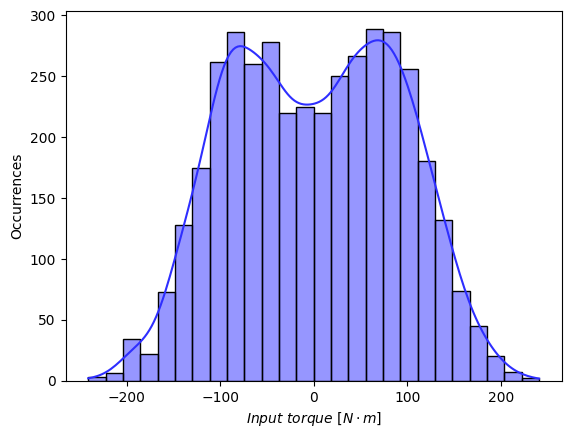

In [3]:
import seaborn as sns
df = pd.read_csv('Datasets/Braccio/input.csv')

sns.set_palette(sns.color_palette("bwr", 10))

# Create a histogram using seaborn
sns.histplot(df["T_in"], kde=True, )


plt.xlabel(r'$Input \  torque \ [N \cdot m]$')
plt.ylabel('Occurrences')
# Show the plot
plt.show()

In [4]:
def add_gaussian_noise(data, mean=0, std_dev=1):
    noise = np.random.normal(mean, std_dev, size=data.shape)
    noisy_data = data + noise
    return noisy_data

def sindyfy_dataset(df, output_column):
  x_sindy = df.copy()
  x_sindy[output_column] = x_sindy[output_column].shift()
  x_sindy = x_sindy.dropna()
  u_sindy = x_sindy.drop(output_column, axis=1)
  x_sindy = x_sindy[output_column]

  x_sindy.reset_index(inplace=True, drop=True)
  u_sindy.reset_index(inplace=True, drop=True)
  return x_sindy, u_sindy
  

# T1
df1 = pd.read_csv('Datasets/Braccio/data1.csv')
train_df1, test_df1 = train_test_split(df1, test_size=0.2, shuffle=False)
train_df1.iloc[:,:-1] = add_gaussian_noise(train_df1.iloc[:,:-1], 0, 0.1)  #add a little noise

scaler1 = StandardScaler()
train_df1 = pd.DataFrame(scaler1.fit_transform(train_df1), columns=train_df1.columns)
test_df1 = pd.DataFrame(scaler1.transform(test_df1), columns=test_df1.columns)

y_train1 = train_df1[["T1"]].iloc[1:]
y_test1 = test_df1[["T1"]].iloc[1:]
x_train1 = train_df1.drop(["T1"], axis=1).iloc[1:]
x_test1 = test_df1.drop(["T1"], axis=1).iloc[1:]

x_test1.reset_index(inplace=True, drop=True)
y_test1.reset_index(inplace=True, drop=True)

x_train_sindy1, u_train_sindy1 = sindyfy_dataset(train_df1, ["T1"])
x_test_sindy1, u_test_sindy1 = sindyfy_dataset(test_df1, ["T1"])
feature_names1 = [*x_train_sindy1.columns.to_list(), *u_train_sindy1.columns.to_list()]


# T1
df2 = pd.read_csv('Datasets/Braccio/data2.csv')
train_df2, test_df2 = train_test_split(df2, test_size=0.2, shuffle=False)
train_df2.iloc[:,:-1] = add_gaussian_noise(train_df2.iloc[:,:-1], 0, 0.1)  #add a little noise

scaler2 = StandardScaler()
train_df2 = pd.DataFrame(scaler2.fit_transform(train_df2), columns=train_df2.columns)
test_df2 = pd.DataFrame(scaler2.transform(test_df2), columns=test_df2.columns)

y_train2 = train_df2[["T2"]].iloc[1:]
y_test2 = test_df2[["T2"]].iloc[1:]
x_train2 = train_df2.drop(["T2"], axis=1).iloc[1:]
x_test2 = test_df2.drop(["T2"], axis=1).iloc[1:]

x_test2.reset_index(inplace=True, drop=True)
y_test2.reset_index(inplace=True, drop=True)

x_train_sindy2, u_train_sindy2 = sindyfy_dataset(train_df2, ["T2"])
x_test_sindy2, u_test_sindy2 = sindyfy_dataset(test_df2, ["T2"])
feature_names2 = [*x_train_sindy2.columns.to_list(), *u_train_sindy2.columns.to_list()]

## Sindy

In [8]:
poly_library = ps.PolynomialLibrary(degree=2, include_interaction=True, include_bias=True)

trigonometric_library = ps.CustomLibrary(
    library_functions= [lambda x: np.sin(x), lambda x,y: np.sin(x+y), lambda x,y: np.sin(x-y), 
                        lambda x,y: np.sin(x*y), lambda x,y: np.sin(x/y),
                        lambda x: np.sin(x**2), lambda x,y: np.sin((x**2)+(y**2)), lambda x,y: np.sin((x**2)-(y**2)), 
                        lambda x,y: np.sin((x**2)*(y**2)), lambda x,y: np.sin((x**2)/(y**2))],

    function_names= [lambda x: f"sin({x})", lambda x,y: f"sin({x}+{y})", lambda x,y: f"sin({x}-{y})", 
                     lambda x,y: f"sin({x}*{y})", lambda x,y: f"sin({x}/{y})",
                     lambda x: f"sin({x}^2)", lambda x,y: f"sin({x}^2+{y}^2)", lambda x,y: f"sin({x}^2-{y}^2)", lambda x,y: f"sin({x}^2*{y}^2)", 
                     lambda x,y: f"sin({x}^2/{y}^2)"]
)

basic_library = ps.CustomLibrary(
    library_functions= [lambda x: x**2, lambda x: 1/x],
    function_names= [lambda x: f"{x}^2", lambda x: f"1/{x}"]
)

exp_library = ps.CustomLibrary(
    library_functions= [lambda x: np.exp(x), lambda x,y: np.exp(x+y), lambda x,y: np.exp(x-y)], 
    function_names=[lambda x: f"exp({x})", lambda x,y: f"exp({x}+{y})", lambda x,y: f"exp({x}-{y})"]
)

# Generate an input matrix reference
inputs_per_library = np.reshape(np.tile([0,1,2,3,4,5,6], 2), (2,7))
inputs_per_library[:, 0] = 2

lib_tensored = ps.GeneralizedLibrary(
    libraries=[poly_library, trigonometric_library*poly_library],
      inputs_per_library=inputs_per_library)


# The shape is the same, different torque name tho
# lib_tensored.fit(pd.concat([x_train_sindy1, u_train_sindy1]))
# lib_tensored.get_feature_names()


In [128]:
lambdas = np.arange(0,0.1,0.001)
scores1 = []
coeffs1 = []
scores2 = []
coeffs2 = []

for l in lambdas:
    model = ps.SINDy(
        optimizer=ps.STLSQ(threshold=l),
        feature_library=lib_tensored,
        discrete_time=True,
        feature_names=feature_names1
    )
    model.fit(x_train_sindy1, u=u_train_sindy1, quiet=True)
    c = model.coefficients()
    coeffs1.append(np.sum(model.coefficients() >= 0.001, axis=1))
    y_pred = model.predict(x_train_sindy1, u=u_train_sindy1)
    scores1.append(mean_squared_error(y_train1, y_pred, squared=False))


for l in lambdas:
    model = ps.SINDy(
        optimizer=ps.STLSQ(threshold=l),
        feature_library=lib_tensored,
        discrete_time=True,
        feature_names=feature_names2
    )
    model.fit(x_train_sindy2, u=u_train_sindy2, quiet=True)
    c = model.coefficients()
    coeffs2.append(np.sum(model.coefficients() >= 0.001, axis=1))
    y_pred = model.predict(x_train_sindy2, u=u_train_sindy2)
    scores2.append(mean_squared_error(y_train2, y_pred, squared=False))

scores1 = np.array(scores1)
coeffs1 = np.array(coeffs1)
scores2 = np.array(scores2)
coeffs2 = np.array(coeffs2)

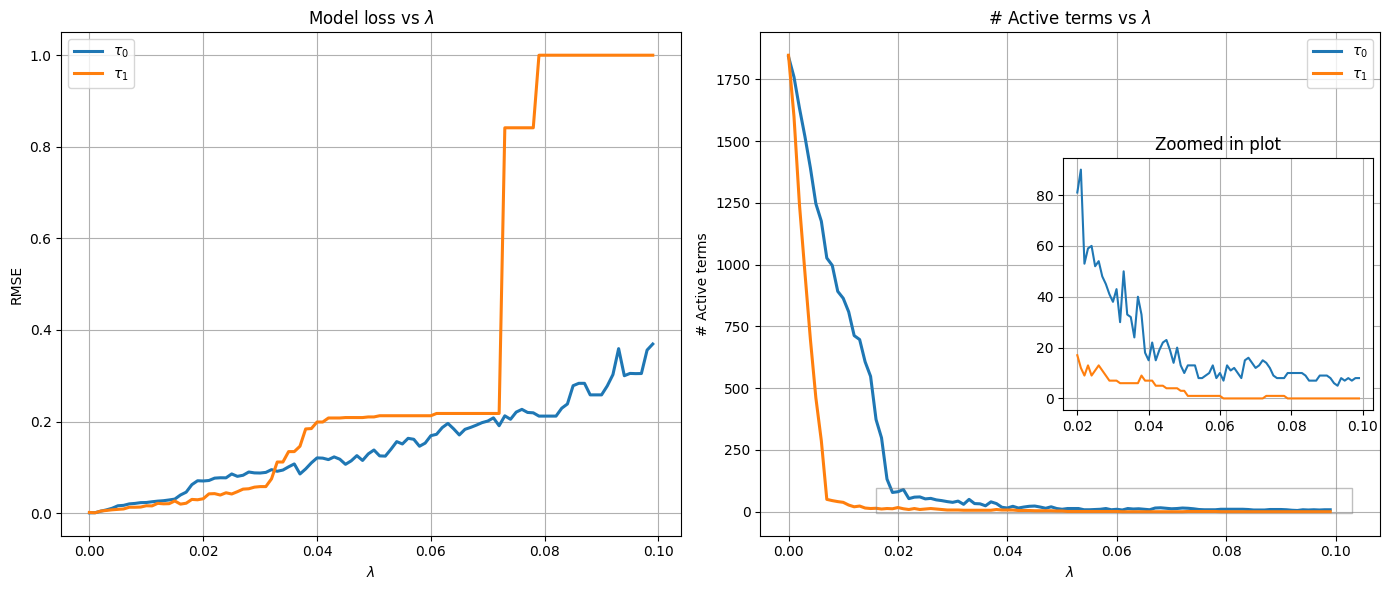

In [129]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].plot(lambdas, scores1, label=r"$\tau_0$", linewidth=2.2)
axes[0].plot(lambdas, scores2, label=r"$\tau_1$", linewidth=2.2)
axes[0].set_xlabel("$\lambda$")
axes[0].set_ylabel("RMSE")
axes[0].set_title("Model loss vs $\lambda$")
axes[0].legend()
axes[0].grid()


axes[1].plot(lambdas, coeffs1, label=r"$\tau_0$", linewidth=2.2)
axes[1].plot(lambdas, coeffs2, label=r"$\tau_1$", linewidth=2.2)
axes[1].set_xlabel("$\lambda$")
axes[1].set_ylabel("# Active terms")


axins = inset_axes(axes[1], width='50%', height='50%', loc='center right')
axins.plot(lambdas[20:], coeffs1[20:], label=r"$\tau_0$")
axins.plot(lambdas[20:], coeffs2[20:], label=r"$\tau_1$")
# axins.set_xlabel("$\lambda$")
# axins.set_ylabel("# Active terms")
axins.set_title("Zoomed in plot")
axins.grid()

axes[1].indicate_inset_zoom(axins)
axes[1].set_title("# Active terms vs $\lambda$")
axes[1].legend()
axes[1].grid()

plt.tight_layout()

In [9]:
sindy_model1 = ps.SINDy(
    optimizer=ps.STLSQ(threshold=0.06),
    feature_library=lib_tensored,
    feature_names=feature_names1,
    discrete_time=True
)
sindy_model1.fit(x_train_sindy1, u=u_train_sindy1)
sindy_model1.print()

(T1)[k+1] = 0.542 O1_dot_dot[k] + -0.607 O2_dot_dot[k] + -0.353 sin(O1[k]) O1[k] + -0.906 sin(O2[k]) O2_dot_dot[k] + -0.212 sin(O2[k]) O1_dot[k]^2 + -0.678 sin(O2[k]) O1_dot[k] O2_dot[k] + 0.072 sin(O2[k]) O1_dot[k] O1_dot_dot[k] + -0.103 sin(O2[k]) O2_dot[k]^2 + 0.204 sin(O1_dot[k]) O2[k] O2_dot[k] + -0.224 sin(O1_dot_dot[k]) 1 + -0.104 sin(O1[k]+O2[k]) O1[k] O2_dot_dot[k] + -0.125 sin(O2[k]+O1_dot[k]) O2[k] O1_dot[k] + 0.128 sin(O2[k]+O1_dot[k]) O1_dot[k] O2_dot[k] + -0.090 sin(O2[k]+O2_dot[k]) O2[k]^2 + -0.300 sin(O2[k]+O2_dot[k]) O2[k] O1_dot[k] + -0.347 sin(O2[k]+O2_dot[k]) O2[k] O2_dot[k] + -0.177 sin(O2[k]+O2_dot[k]) O1_dot[k] O2_dot[k] + 0.190 sin(O2[k]+O1_dot_dot[k]) 1 + 0.125 sin(O1[k]-O2_dot_dot[k]) 1 + 0.107 sin(O2[k]-O1_dot[k]) O2[k] O1_dot[k] + -0.201 sin(O2[k]-O1_dot[k]) O1_dot[k] O2_dot[k] + -0.272 sin(O2[k]-O1_dot[k]) O2_dot[k]^2 + 0.320 sin(O2[k]-O2_dot[k]) O2[k] O1_dot[k] + 0.324 sin(O2[k]-O2_dot[k]) O2[k] O2_dot[k] + 0.157 sin(O2[k]-O2_dot[k]) O1_dot[k]^2 + -0.227 s

In [10]:
sindy_model2 = ps.SINDy(
    optimizer=ps.STLSQ(threshold=0.07),
    feature_library=lib_tensored,
    feature_names=feature_names2,
    discrete_time=True
)
sindy_model2.fit(x_train_sindy2, u=u_train_sindy2)
sindy_model2.print()

(T2)[k+1] = 0.376 O2_dot[k] + -0.802 sin(O2[k]) O2[k] O2_dot[k] + 0.346 sin(O2[k]) O1_dot[k] O1_dot_dot[k] + 0.340 sin(O2[k]) O2_dot[k]^2 + 0.090 sin(O2_dot[k]) O1[k] O2_dot_dot[k] + 0.501 sin(O2_dot[k]) O2[k] O2_dot_dot[k] + -0.293 sin(O1_dot_dot[k]) O1_dot[k] O2_dot_dot[k] + -0.172 sin(O1[k]+O2[k]) O1[k] O2_dot[k] + -0.160 sin(O1[k]+O2[k]) O2[k] O2_dot[k] + 0.181 sin(O1[k]+O2[k]) O1_dot[k] O2_dot_dot[k] + 0.214 sin(O2[k]+O1_dot[k]) O2[k] O2_dot[k] + 0.537 sin(O2[k]+O1_dot[k]) O2[k] O1_dot_dot[k] + 0.179 sin(O2[k]+O1_dot[k]) O1_dot[k] O2_dot[k] + -0.145 sin(O2[k]+O1_dot[k]) O1_dot[k] O2_dot_dot[k] + -0.226 sin(O2[k]+O1_dot[k]) O2_dot[k]^2 + -0.519 sin(O2[k]+O2_dot[k]) O2[k] O1_dot_dot[k] + -0.357 sin(O2[k]+O2_dot[k]) O2[k] O2_dot_dot[k] + 0.169 sin(O2[k]+O2_dot[k]) O1_dot[k]^2 + 0.312 sin(O2[k]+O2_dot[k]) O2_dot[k] O1_dot_dot[k] + 0.357 sin(O2[k]+O2_dot_dot[k]) O1_dot[k] O1_dot_dot[k] + -0.272 sin(O1_dot[k]+O2_dot[k]) O2_dot[k] O1_dot_dot[k] + -0.315 sin(O1_dot[k]+O2_dot[k]) O2_dot[k]

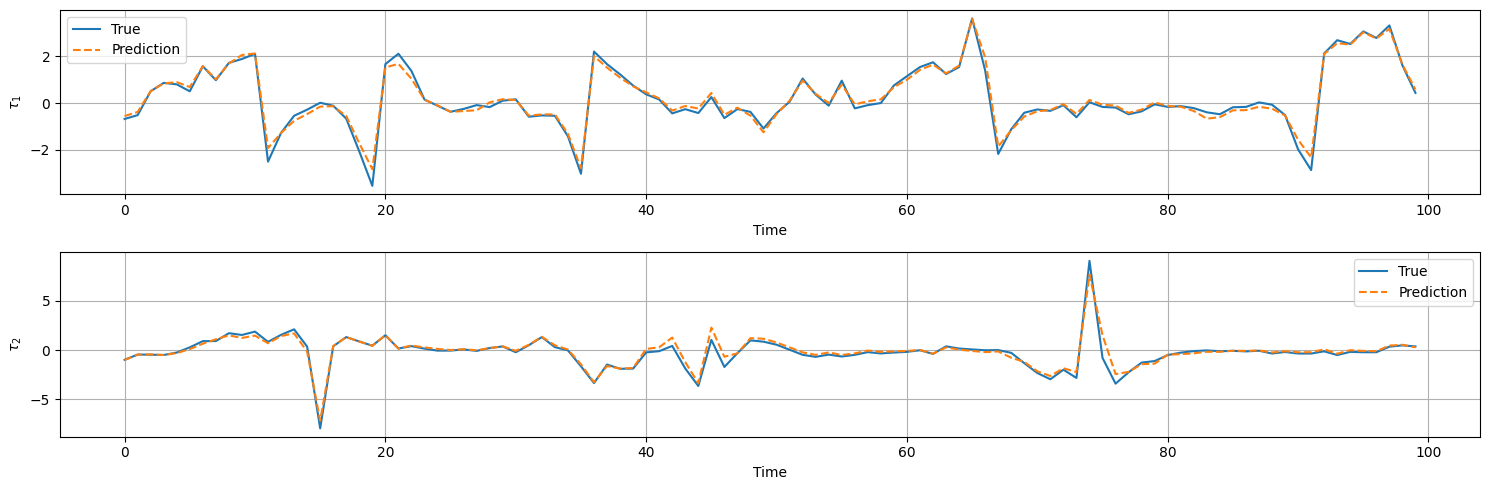

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(15, 5))

y_pred1 = sindy_model1.predict(x_test_sindy1, u=u_test_sindy1)
y_pred2 = sindy_model2.predict(x_test_sindy2, u=u_test_sindy2)

axes[0].plot(y_test1[:100], label=f'True')
axes[0].plot(y_pred1[:100], label=f'Prediction', linestyle='--')
axes[0].grid()
axes[0].legend()
axes[0].set_xlabel("Time")
axes[0].set_ylabel(r"$\tau_1$")

axes[1].plot(y_test2[:100], label=f'True')
axes[1].plot(y_pred2[:100], label=f'Prediction', linestyle='--')
axes[1].grid()
axes[1].legend()
axes[1].set_xlabel("Time")
axes[1].set_ylabel(r"$\tau_2$")

plt.tight_layout()

In [39]:
mapes = []
r2s = []
rmses = []

y_pred = sindy_model1.predict(x_test_sindy1, u=u_test_sindy1)
mapes.append(mean_absolute_percentage_error(y_test1, y_pred))
r2s.append(r2_score(y_test1, y_pred))
rmses.append(mean_squared_error(y_test1, y_pred, squared=False))

y_pred = sindy_model2.predict(x_test_sindy2, u=u_test_sindy2)
mapes.append(mean_absolute_percentage_error(y_test2, y_pred))
r2s.append(r2_score(y_test2, y_pred))
rmses.append(mean_squared_error(y_test2, y_pred, squared=False))

print("mape: ", mapes, "   mean: ", np.mean(mapes))
print("r2: ", r2s, "   mean: ", np.mean(r2s))
print("rmse: ", rmses, "   mean: ", np.mean(rmses))

mape:  [0.9359906186152508, 0.7448282710405252]    mean:  0.840409444827888
r2:  [0.9608546533655593, 0.944037641697873]    mean:  0.9524461475317161
rmse:  [0.29114756924202445, 0.18879028901325734]    mean:  0.2399689291276409


In [15]:
def sindy_callable1_(X):
    return sindy_model1.predict(x=X[:,:x_train1.shape[1]], u=X[:, x_train1.shape[1]:])

def sindy_callable2_(X):
    return sindy_model2.predict(x=X[:,:x_train2.shape[1]], u=X[:, x_train2.shape[1]:])

x_test_stack1 = pd.concat((x_test_sindy1, u_test_sindy1), axis=1).to_numpy()
x_test_stack2 = pd.concat((x_test_sindy2, u_test_sindy2), axis=1).to_numpy()

sindy_explainer = []
sindy_explainer.append(shap.Explainer(sindy_callable1_, x_test_stack1, feature_names=feature_names1))
sindy_explainer.append(shap.Explainer(sindy_callable2_, x_test_stack2, feature_names=feature_names2))

sindy_shap_values = []
sindy_shap_values.append(sindy_explainer[0](x_test_stack1))
sindy_shap_values.append(sindy_explainer[1](x_test_stack2))

ExactExplainer explainer: 800it [06:16,  2.06it/s]                         
ExactExplainer explainer: 800it [06:21,  2.05it/s]                         


In [18]:
# Cleanse values from output

for svalues in sindy_shap_values:
    svalues.values = np.delete(svalues.values, 0, axis=1)
    svalues.data = np.delete(svalues.data, 0, axis=1)

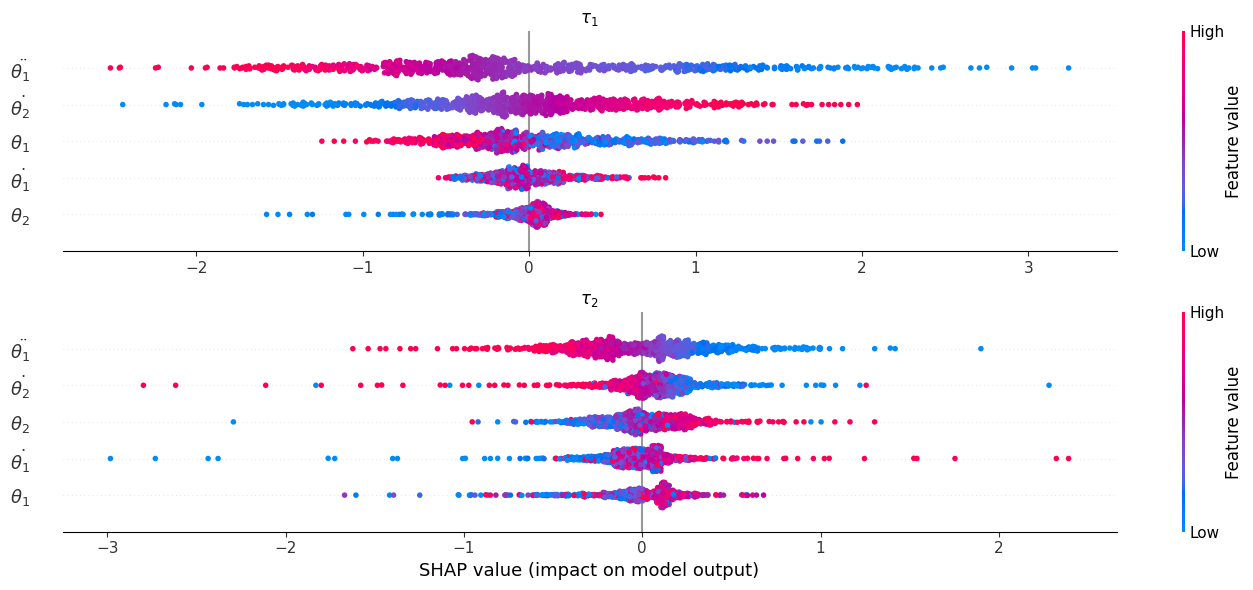

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(14, 6))
l = [r'$\tau_1$', r'$\tau_2$']
dot = '\u0307'

for i, shap_values in enumerate(sindy_shap_values):
    plt.sca(axes[i])
    shap.summary_plot(shap_values, show=False, feature_names=[r'$\theta_1$', r'$\theta_2$', r'$\dot{\theta_1}$', r'$\dot{\theta_2}$', r'$\ddot{\theta_1}$',  r'$\ddot{\theta_2}$'], plot_size=None)
    plt.title(f"{l[i]}")
    
    if i != 1:
        plt.xlabel("")


plt.tight_layout()

## Operon

In [20]:
regs = [SymbolicRegressor(
        allowed_symbols='add,sub,mul,div,sin,cos,constant,variable,exp',
        offspring_generator='basic',
        local_iterations=60,
        max_length=50,
        initialization_method='btc',
        n_threads=32,
        objectives=['rmse'],
        random_state=None,
        reinserter='replace-worst',
        max_evaluations=int(1e6),
        symbolic_mode=False,
        ) for _ in range(2)]


regs[0].fit(x_train1, y_train1)
regs[1].fit(x_train2, y_train2)

SymbolicRegressor(allowed_symbols='add,sub,mul,div,sin,cos,constant,variable,exp',
                  local_iterations=60, n_threads=32, objectives=['rmse'],
                  pool_size=1000, random_state=2347617384596604407,
                  symbolic_mode=False, time_limit=9223372036854775807)

In [21]:
import sympy
from IPython.display import display
feature_names = x_train1.columns.to_list()

equation = regs[0].get_model_string(regs[0].model_, names=feature_names1, precision=3)
display(sympy.parsing.sympy_parser.parse_expr(equation).evalf(2))
print(regs[0].stats_)
print()

equation = regs[1].get_model_string(regs[1].model_, names=feature_names2, precision=3)
display(sympy.parsing.sympy_parser.parse_expr(equation).evalf(2))
print(regs[1].stats_)
print()

0.039*O1 - 0.68*O1_dot_dot + 0.0011*O2 + 0.25*O2_dot + 1.1*(12.0*O1_dot_dot + 1.2*T1)*(-0.006*T1 - 0.052)*sin(1.778*O1 + 0.008*O1_dot_dot - 0.01*O2 + 0.447) + 1.1*(cos(0.929*O1_dot + 0.497*O2 - 0.103) - 0.94)*sin(1.633*O1 + 0.033*O1_dot_dot + 0.999967181313488 - exp(-0.116*O1_dot)) - 0.26

{'model_length': 50, 'model_complexity': 84, 'generations': 33, 'evaluation_count': 33454, 'residual_evaluations': 600040, 'jacobian_evaluations': 401739, 'random_state': 2472919443813460304}



-38.0*O1_dot*(cos(-1.686*O1 + 0.004*O2 + 0.002) + 0.004) + 1.0*(-2.0*O2*(6.1*O1 + 1.8*O2_dot) + 3.0)*(0.016*O1 - 0.029*O2_dot - 0.001) + 1.0*(cos(0.012*O1 - 0.101*O2 + 0.019*O2_dot) - 1.5)*(0.13*O1 - 79.0*O1_dot*cos(1.68*O1 + 0.014*O2_dot) + 1.4*O1_dot_dot - 0.55*O2 + 0.67*O2_dot)

{'model_length': 50, 'model_complexity': 86, 'generations': 38, 'evaluation_count': 38347, 'residual_evaluations': 594437, 'jacobian_evaluations': 407085, 'random_state': 2347617384596604407}



In [22]:
import sympy
from IPython.display import display
feature_names = x_train1.columns.to_list()

equation = regs[0].get_model_string(regs[0].model_, names=feature_names1, precision=3)
print(sympy.latex(sympy.parsing.sympy_parser.parse_expr(equation).evalf(2)))
print(regs[0].stats_)
print()

equation = regs[1].get_model_string(regs[1].model_, names=feature_names2, precision=3)
print(sympy.latex(sympy.parsing.sympy_parser.parse_expr(equation).evalf(2)))
print(regs[1].stats_)
print()

0.039 O_{1} - 0.68 O_{1 dot dot} + 0.0011 O_{2} + 0.25 O_{2 dot} + 1.1 \cdot \left(12.0 O_{1 dot dot} + 1.2 T_{1}\right) \left(- 0.006 T_{1} - 0.052\right) \sin{\left(1.778 O_{1} + 0.008 O_{1 dot dot} - 0.01 O_{2} + 0.447 \right)} + 1.1 \left(\cos{\left(0.929 O_{1 dot} + 0.497 O_{2} - 0.103 \right)} - 0.94\right) \sin{\left(1.633 O_{1} + 0.033 O_{1 dot dot} + 0.999967181313488 - e^{- 0.116 O_{1 dot}} \right)} - 0.26
{'model_length': 50, 'model_complexity': 84, 'generations': 33, 'evaluation_count': 33454, 'residual_evaluations': 600040, 'jacobian_evaluations': 401739, 'random_state': 2472919443813460304}

- 38.0 O_{1 dot} \left(\cos{\left(- 1.686 O_{1} + 0.004 O_{2} + 0.002 \right)} + 0.004\right) + 1.0 \left(- 2.0 O_{2} \cdot \left(6.1 O_{1} + 1.8 O_{2 dot}\right) + 3.0\right) \left(0.016 O_{1} - 0.029 O_{2 dot} - 0.001\right) + 1.0 \left(\cos{\left(0.012 O_{1} - 0.101 O_{2} + 0.019 O_{2 dot} \right)} - 1.5\right) \left(0.13 O_{1} - 79.0 O_{1 dot} \cos{\left(1.68 O_{1} + 0.014 O_{2 do

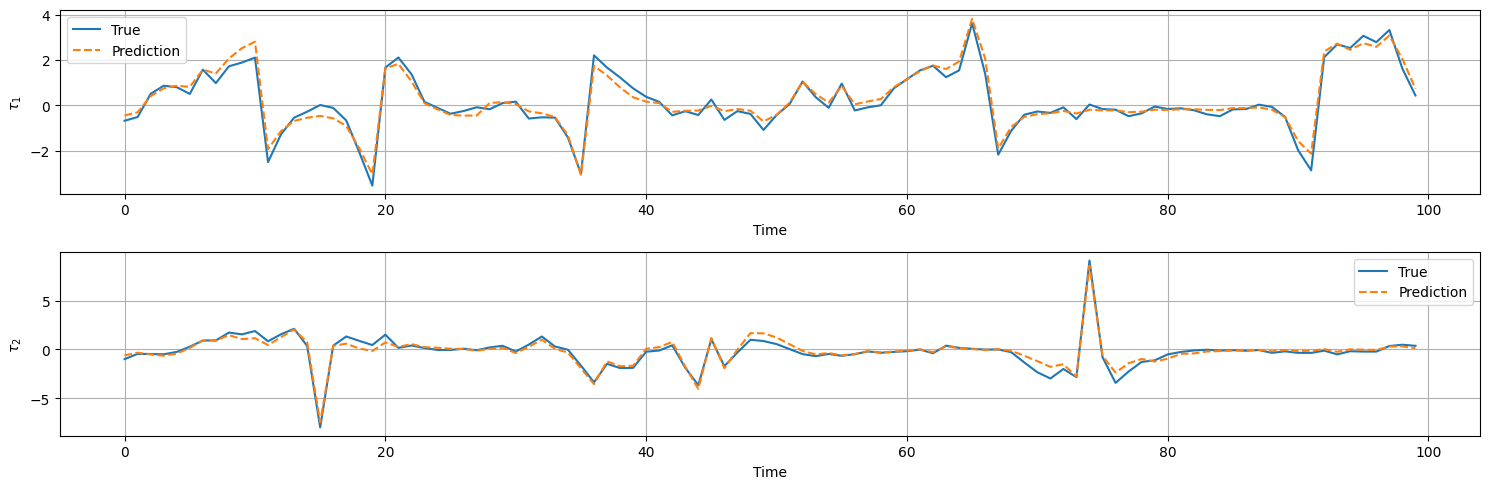

In [28]:
fig, axes = plt.subplots(2, 1, figsize=(15, 5))

y_pred1 = regs[0].predict(x_test1)
y_pred2 = regs[1].predict(x_test2)

axes[0].plot(y_test1[:100], label=f'True')
axes[0].plot(y_pred1[:100], label=f'Prediction', linestyle='--')
axes[0].grid()
axes[0].legend()
axes[0].set_xlabel("Time")
axes[0].set_ylabel(r"$\tau_1$")

axes[1].plot(y_test2[:100], label=f'True')
axes[1].plot(y_pred2[:100], label=f'Prediction', linestyle='--')
axes[1].grid()
axes[1].legend()
axes[1].set_xlabel("Time")
axes[1].set_ylabel(r"$\tau_2$")

plt.tight_layout()

In [118]:
def neighborhood(x, X_train, factor, size=100):
    """Method to create samples around a given observation x.

    This method uses a multivariate normal distribution to
    randomly select feature values. The sigma of the distribution
    is calculated over the training data to mimic the original
    distributions and a scaling factor is multiplied to
    adjust how large will be the neighborhood.

    It is possible to specify the number of generated samples
    by setting the size to a different value (default=100).

    Returns a matrix of shape (size, n_features) containing
    the sampled neighbors.

    """

    if x.ndim == 2:
        assert x.shape[0] == 1, \
            ("The neighborhood is created based only in a single observation. "
            f"The given data x has {x.shape[0]} observations.")

        # we need x to be a 1-dimensional array
        x = np.squeeze(x)

    if x.shape[0]==1:
        return np.random.normal(
            x, np.var(X_train)*factor, size=size).reshape(-1, 1)

    return np.random.multivariate_normal(
        x, np.cov(X_train.T)*factor, size=size)

In [25]:
x_tests = [x_test1, x_test2]
operon_explainer = [shap.Explainer(reg.predict, x_test, feature_names=feature_names) for reg, x_test in zip(regs, x_tests)]
operon_shap_values = [explainer(x_test) for explainer, x_test in zip(operon_explainer, x_tests)]

In [23]:
x_test1

,O1,O2,O1_dot,O2_dot,O1_dot_dot,O2_dot_dot
0,1.010134,0.877563,0.709654,0.463296,0.078001,0.056405
1,1.081980,0.945151,0.772142,0.455914,0.253327,-0.029331
2,1.171727,1.001582,1.024818,0.343513,1.026762,-0.441601
3,1.290733,1.032930,1.311570,0.175089,1.165340,-0.661529
4,1.435724,1.031896,1.514076,-0.019117,0.822736,-0.762743
...,...,...,...,...,...,...
794,0.155752,-0.188740,0.019434,-0.960345,-0.540676,0.326482
795,0.134200,-0.349399,-0.263581,-0.709655,-1.151725,0.983774
796,0.080631,-0.462081,-0.564708,-0.430652,-1.225382,1.094919
797,-0.010225,-0.514468,-0.944666,-0.040335,-1.545962,1.531898


In [24]:
feature_names

['O1', 'O2', 'O1_dot', 'O2_dot', 'O1_dot_dot', 'O2_dot_dot']

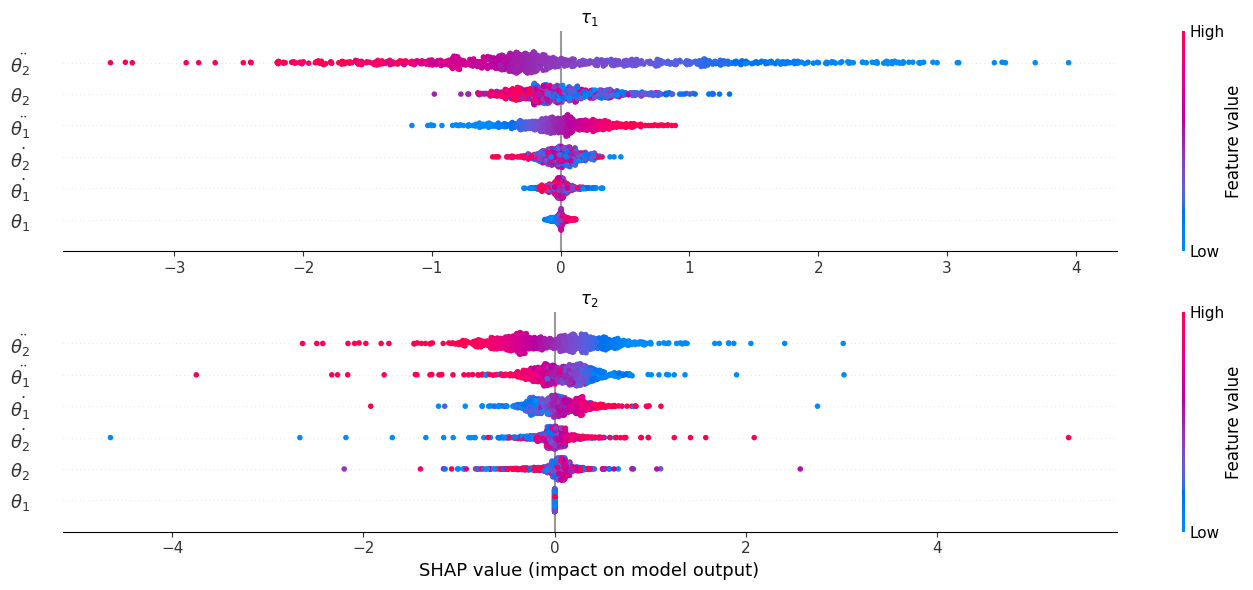

In [26]:
fig, axes = plt.subplots(2, 1, figsize=(14, 6))
l = [r'$\tau_1$', r'$\tau_2$']
dot = '\u0307'

for i, shap_values in enumerate(operon_shap_values):
    plt.sca(axes[i])
    shap.summary_plot(shap_values, show=False, feature_names=[r'$\theta_1$', r'$\theta_2$', r'$\dot{\theta_1}$', r'$\dot{\theta_2}$', r'$\ddot{\theta_1}$',  r'$\ddot{\theta_2}$'], plot_size=None)
    plt.title(f"{l[i]}")
    
    if i != 1:
        plt.xlabel("")


plt.tight_layout()

## PySR

In [27]:
from pysr import PySRRegressor
model1 = PySRRegressor.from_file('julia/saved_models/braccio1.pkl')
model2 = PySRRegressor.from_file('julia/saved_models/braccio2.pkl')
best_models = [6,23]
pysr_models = [model1, model2]

Checking if julia/saved_models/braccio1.pkl exists...
Loading model from julia/saved_models/braccio1.pkl
Checking if julia/saved_models/braccio2.pkl exists...
Loading model from julia/saved_models/braccio2.pkl


In [22]:
print("t1: ")
display(model1.equations_.iloc[best_models[0],4].evalf(3))
print("t2: ")
display(model2.equations_.iloc[best_models[1],4].evalf(3))

t1: 


-1.36*O2_dot_dot*sin(O2 + 1.0233049) - 0.274

t2: 


-0.389*O1_dot*O2_dot*(O1_dot + 0.445*O2_dot_dot)*(O2**2 - 0.975) - 0.389*O1_dot_dot*((-1.9*O1_dot + O2_dot)*sin(1.6751664*O2) + 1.28) - 0.779*O2_dot_dot

In [41]:
print("t1: ")
print(sympy.latex(model1.equations_.iloc[best_models[0],4].evalf(2)))
print("t2: ")
display(sympy.latex(model2.equations_.iloc[best_models[1],4].evalf(2)))

t1: 
- 1.4 O_{2 dot dot} \sin{\left(O_{2} + 1.0233049 \right)} - 0.27
t2: 


'- 0.39 O_{1 dot} O_{2 dot} \\left(O_{1 dot} + 0.45 O_{2 dot dot}\\right) \\left(O_{2}^{2} - 0.98\\right) - 0.39 O_{1 dot dot} \\left(\\left(- 1.9 O_{1 dot} + O_{2 dot}\\right) \\sin{\\left(1.6751664 O_{2} \\right)} + 1.3\\right) - 0.78 O_{2 dot dot}'

In [20]:
r2_score(y_true=y_test2, y_pred=model.predict(x_test2, 23))

0.9035329147139886

r2 train (sklearn.r2_score):  0.9260792051058626
r2 train (sklearn.r2_score):  0.9035329147139886


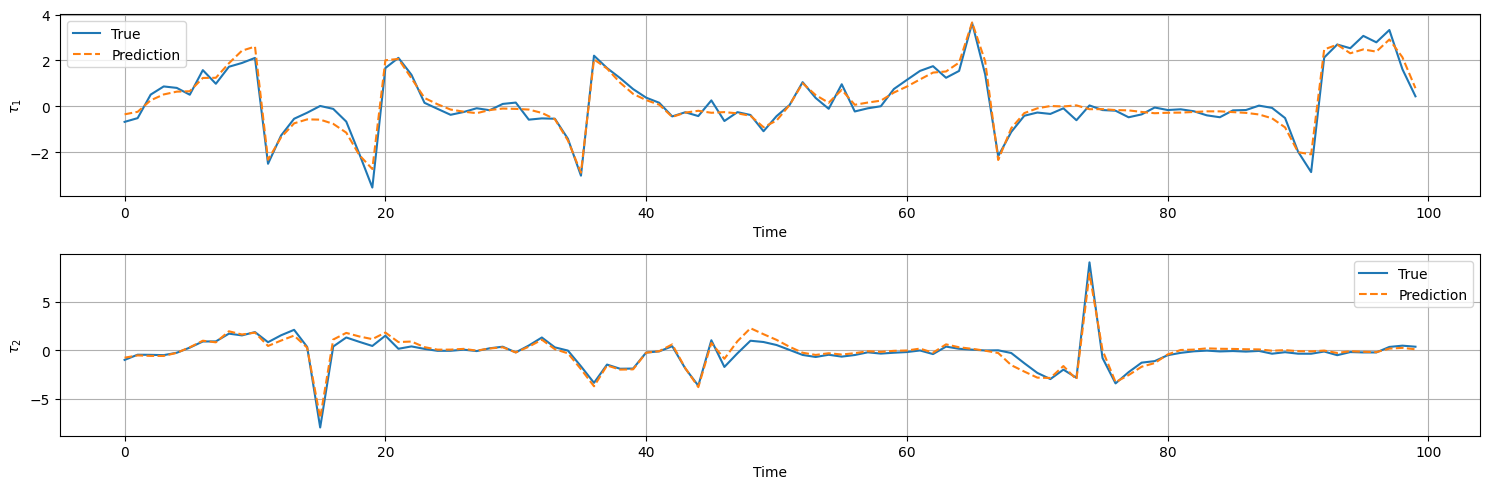

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(15, 5))

y_pred_test1 = model1.predict(x_test1, best_models[0])
y_true1 = y_test1
print('r2 train (sklearn.r2_score): ', r2_score(y_true1, y_pred_test1))
axes[0].plot(y_true1[:100], label='True')
axes[0].plot(y_pred_test1[:100], label=f'Prediction', linestyle='--')
axes[0].grid()
axes[0].legend()
axes[0].set_xlabel("Time")
axes[0].set_ylabel(r"$\tau_1$")

y_pred_test2 = model2.predict(x_test2, best_models[1])
y_true2 = y_test2
print('r2 train (sklearn.r2_score): ', r2_score(y_true2, y_pred_test2))
axes[1].plot(y_true2[:100], label='True')
axes[1].plot(y_pred_test2[:100], label=f'Prediction', linestyle='--')
axes[1].grid()
axes[1].legend()
axes[1].set_xlabel("Time")
axes[1].set_ylabel(r"$\tau_2$")

plt.tight_layout()

In [31]:
mapes = []
r2s = []
rmses = []


y_pred = model1.predict(x_test1)
mapes.append(mean_absolute_percentage_error(y_true1, y_pred))
r2s.append(r2_score(y_true1, y_pred))
rmses.append(mean_squared_error(y_true1, y_pred, squared=False))

y_pred = model2.predict(x_test2)
mapes.append(mean_absolute_percentage_error(y_true2, y_pred))
r2s.append(r2_score(y_true2, y_pred))
rmses.append(mean_squared_error(y_true2, y_pred, squared=False))

print("mape: ", mapes, "   mean: ", np.mean(mapes))
print("r2: ", r2s, "   mean: ", np.mean(r2s))
print("rmse: ", rmses, "   mean: ", np.mean(rmses))

mape:  [1.5422107583077789, 1.5041630910952417]    mean:  1.5231869247015104
r2:  [0.9260792051058626, 0.9035329147139886]    mean:  0.9148060599099256
rmse:  [0.40008881583896844, 0.24786843560944097]    mean:  0.3239786257242047


In [31]:
pysr_explainer = []
pysr_explainer.append(shap.Explainer(model1.predict, x_test1, feature_names=feature_names))
pysr_explainer.append(shap.Explainer(model2.predict, x_test2, feature_names=feature_names))

pysr_shap_values = []
pysr_shap_values.append(pysr_explainer[0](x_test1))
pysr_shap_values.append(pysr_explainer[1](x_test2))

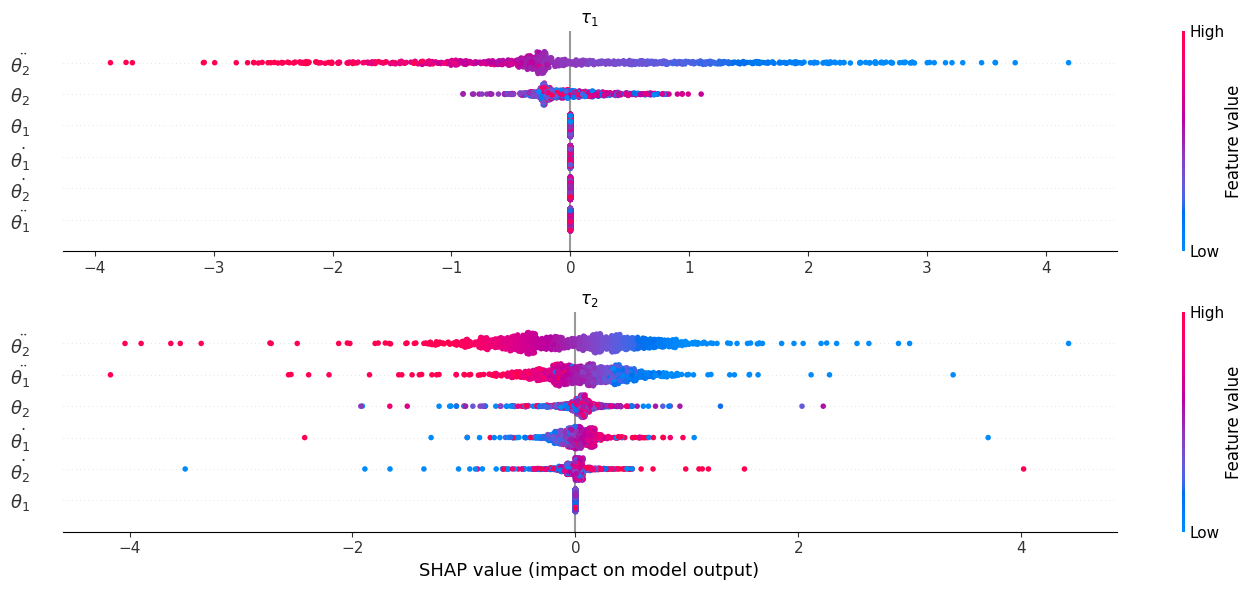

In [32]:
fig, axes = plt.subplots(2, 1, figsize=(14, 6))
l = [r'$\tau_1$', r'$\tau_2$']
dot = '\u0307'

for i, shap_values in enumerate(pysr_shap_values):
    plt.sca(axes[i])
    shap.summary_plot(shap_values, show=False, feature_names=[r'$\theta_1$', r'$\theta_2$', r'$\dot{\theta_1}$', r'$\dot{\theta_2}$', r'$\ddot{\theta_1}$',  r'$\ddot{\theta_2}$'], plot_size=None)
    plt.title(f"{l[i]}")
    
    if i != 1:
        plt.xlabel("")


plt.tight_layout()